In [13]:
from mixer.models.modeling import MlpMixer, CONFIGS
import numpy as np
from cka_heatmap import compute_heatmap, display_heatmap, cka_linear
from data_loaders import get_imagenet_test_loader, get_cifar10_val_loader

In [14]:
def load_mixer(config, path):
    mixer = MlpMixer(config, num_classes=1000 if '21k' not in path else 21843)
    mixer.load_from(np.load(path))
    return mixer

In [15]:
def get_activation_hook(act, idx):
    def hook(model, input, output):
        act[idx] = output.detach().numpy()
    return hook


def add_hooks(mixer):
    act = [None for _ in mixer.layer]
    for i, layer in enumerate(mixer.layer):
        layer.register_forward_hook(get_activation_hook(act, i))
    return act


def get_activations(mixer, loader):
    act = add_hooks(mixer)
    _ = mixer(next(iter(loader))[0])
    return act

In [19]:
def mixer_heatmap(mixer):
    loader = get_cifar10_val_loader(1)
    act = get_activations(mixer, loader)
    act = [x.reshape(x.shape[0], np.prod(x.shape[1:])) for x in act]
    print(act[0].shape)
    heatmap = compute_heatmap(act, act)
    display_heatmap(heatmap)

In [17]:
mixers = [
    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/gsam/Mixer-B_16.npz"),
    (CONFIGS['Mixer-B_32'], "mixer/checkpoint/gsam/Mixer-B_32.npz"),
    (CONFIGS['Mixer-S_8'], "mixer/checkpoint/gsam/Mixer-S_8.npz"),
    (CONFIGS['Mixer-S_16'], "mixer/checkpoint/gsam/Mixer-S_16.npz"),
    (CONFIGS['Mixer-S_32'], "mixer/checkpoint/gsam/Mixer-S_32.npz"),
    
    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/imagenet1k/Mixer-B_16.npz"),
    (CONFIGS['Mixer-L_16'], "mixer/checkpoint/imagenet1k/Mixer-L_16.npz"),

    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/imagenet21k/Mixer-B_16.npz"),
    (CONFIGS['Mixer-L_16'], "mixer/checkpoint/imagenet21k/Mixer-L_16.npz"),

    (CONFIGS['Mixer-B_16'], "mixer/checkpoint/sam/Mixer-B_16.npz"),
    (CONFIGS['Mixer-B_32'], "mixer/checkpoint/sam/Mixer-B_32.npz"),
]

MODEL: mixer/checkpoint/Mixer-B_16.npz
Files already downloaded and verified
(1, 150528)


/home/calvin/Documents/URI/CSC561/csc561-final/pytorch-mixer/CKA_Google.py:31: RuntimeWarning: invalid value encountered in divide
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


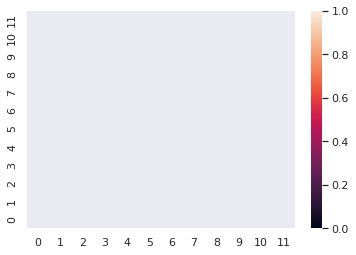

In [20]:
for config, path in [(CONFIGS['Mixer-B_16'], "mixer/checkpoint/Mixer-B_16.npz")]:
    print(f"MODEL: {path}")
    mixer = load_mixer(config, path)
    mixer_heatmap(mixer)
    del mixer